### Import

In [3]:
import numpy as np
import sympy as sp

import matplotlib
import matplotlib.pyplot as plt 
matplotlib.use('Agg')

from sympy import Matrix, init_printing

import qiskit
from qiskit import *

# Representing Data
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

# Monitor Job on Real Machine
from qiskit.tools.monitor import job_monitor

from functools import reduce # perform sucessive tensor product

# Calculating cost
from sklearn.metrics import mean_squared_error

# Generating random unitary matrix
from scipy.stats import unitary_group

# Measure run time
import time

# Almost Equal
from numpy.testing import assert_almost_equal as aae

Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc' line #2.
Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc' line #3.


### Useful Resources

###### Helpful Linear Algebra Matrices and Methods

In [4]:
# Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])

CX = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])

# Eigenvectors of Pauli Matrices
zero = np.array([[1], [0]]) # Z plus basis state
one = np.array([[0], [1]]) # Z plus basis state

plus = np.array([[1], [1]])/np.sqrt(2) # X plus basis state
minus = np.array([[1], [-1]])/np.sqrt(2) # X minus basis state

up = np.array([[1], [1j]])/np.sqrt(2) # Y plus basis state
down = np.array([[1], [-1j]])/np.sqrt(2) # Y plus basis state

# Bell States
B00 = np.array([[1], [0], [0], [1]])/np.sqrt(2) # Bell of 00
B01 = np.array([[1], [0], [0], [-1]])/np.sqrt(2) # Bell of 01
B10 = np.array([[0], [1], [1], [0]])/np.sqrt(2) # Bell of 10
B11 = np.array([[0], [-1], [1], [0]])/np.sqrt(2) # Bell of 11

# Rn Matrix Function
Rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
Rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

# Tensor Product of 2+ matrices/ vectors
tensor = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

###### CX Matrix

In [5]:
def cx_matrix(no_qubits, control, target):
    
    """
    Manually build the unitary matrix for non-adjacent CX gates
    
    Parameters:
    -----------
    no_qubits: int
        Number of qubits in the circuit
    control: int
        Index of the control qubit (1st qubit is index 0)
    target: int
        Index of the target qubit (1st qubit is index 0)
        
    Returns:
    --------
    cx_out:
        Unitary matrix for non-adjacent CX gate
    """

    
    left = [I]*no_qubits
    right = [I]*no_qubits

    left[control] = np.dot(zero, zero.T)
    right[control] = np.dot(one, one.T)

    right[target] = X
    
    cx_out = tensor(*left) + tensor(*right)
          
    return cx_out

###### View Matrix

In [6]:
def view(mat):
    display(Matrix(mat))

###### Get Unitary/StateVector Function

In [7]:
def get(circ, types = 'unitary', nice = True):
    
    """
    This function return the statevector or the unitary of the inputted circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        Inputted circuit without measurement gate
    types: str ('unitary')
        Get 'unitary' or 'statevector' option
    nice: bool
        Display the result nicely option or just return unitary/statevector as ndarray
        
    Returns:
    --------
    out: ndarray
        Outputted unitary of statevector
        
    """
    
    if types == 'statevector':
        backend = BasicAer.get_backend('statevector_simulator')
        out = execute(circ, backend).result().get_statevector()
    else: 
        backend = BasicAer.get_backend('unitary_simulator')
        out = execute(circ, backend).result().get_unitary()
        
    if nice:
        display(Matrix(np.round(out, 10))) 
    else:
        return out

###### Milk (Draw Circuit in Reversed Order)

In [8]:
def milk(circ):
    return circ.draw(output = 'mpl', reverse_bits='false')

###### Convert ndarray to list

In [9]:
to_list = lambda array: list(np.squeeze(array))

###### Displaying Output

In [10]:
def sim(circ, visual = 'hist'):
    
    """
    Displaying output of quantum circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        QuantumCircuit with or without measurement gates
    visual: str ('hist')
        'hist' (counts on histogram) or 'bloch' (statevectors on Bloch sphere) or None (get counts only)
        
    Returns:
    --------
    counts: dict
        Counts of each CBS state
    """
    
    # Simulate circuit and display counts on a histogram
    if visual == 'hist':
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        plot_histogram(counts)
        
        return counts
        
    # Get the statevector and display on a Bloch sphere
    elif visual == 'bloch':
        backend = BasicAer.get_backend('statevector_simulator')
        statevector = execute(circ, backend).result().get_statevector()
        get(circ)
        plot_bloch_multivector(statevector)
        
    # Just get counts
    else:
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        
        return counts

### Problem

The Swap test is a simple quantum circuit which, given two states, allows to compute how much do they differ from each other.

1) Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

2) Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

3) Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. For example, the state $|a\rangle = |01\rangle$ is a product state, while the state $|b\rangle = |00\rangle + |11\rangle$ is not.

Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.


### Research
   - https://en.wikipedia.org/wiki/Swap_test

   - http://www.vcpc.univie.ac.at/~ian/hotlist/qc/talks/bloch-sphere-rotations.pdf

### Plan

#### Part 1:

a. Create a circuit with two rotation gates

b. Create a method to calculate the angles of the two gates based on the desired output.

c. Check correct implementation by displaying statevector on the Bloch sphere

#### Part 2:

a. Build SWAP test complex

b. Create a method for getting the probability of measurement

c. Initialize Circuit Method

d. Full SWAP Circuit + Probability Output

e. Random Search Method

#### Part 3:

a. Method to product hidden product state

b. SWAP test on product state method

### Part 1:

#### a. Create a circuit with two rotation gates

Using the geometric representation of a Bloch sphere, we can see that any ray can be transform from $|0\rangle$ by rotations about two different axes.

In this case, we will use an x-rotation followed an y-rotation

The two rotations used have the following matrix

#### X-axis Rotation

$$R_X( \theta ) = \begin{bmatrix} \cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\ -i \sin \frac{\theta}{2} & \cos \frac{\theta}{2}  \end{bmatrix}$$

#### Y-axis Rotation

$$R_Y( \phi ) = \begin{bmatrix} \cos \frac{\phi}{2} & -\sin \frac{\phi}{2} \\ \sin \frac{\phi}{2} & \cos \frac{\phi}{2}  \end{bmatrix}$$

The product of the two $R_y(\phi)R_x(\theta)$ gives

$$R_y(\phi)R_x(\theta) = \begin{bmatrix} a & b \\ c & d \end{bmatrix}$$

where,

$$a = \cos \frac{\phi}{2}\cos \frac{\theta}{2} + i \sin \frac{\phi}{2}\sin \frac{\theta}{2}$$

$$b = - \sin \frac{\phi}{2}\cos \frac{\theta}{2} - i \cos \frac{\phi}{2}\sin \frac{\theta}{2}$$

$$c = \sin \frac{\phi}{2}\cos \frac{\theta}{2} - i \cos \frac{\phi}{2}\sin \frac{\theta}{2}$$

$$d = \cos \frac{\phi}{2}\cos \frac{\theta}{2} - i \sin \frac{\phi}{2}\sin \frac{\theta}{2}$$

We can implement this on a quantum circuit

In [11]:
def r_circ(phi, theta, measure_gate = False, visual = True):
    
    """
    Build a Quantum Circuit with the rotation gates initialized to the correct angles
    
    Parameters:
    -----------
    phi: float
        Angle to initialize the R_y matrix [0, 2pi)
    theta: float
        Angle to initialize the R_x matrix [0, 2pi)
    measure_gate: bool (False)
        Add measurement gate at the end option
    visual: bool (True)
        Draw circuit option
    
    Returns:
    --------
    circ: QuantumCircuit
        Rotation circuit with inputted angles
    
    """
    
    circ = QuantumCircuit(1, 1)

    # Parametric gates
    circ.rx(theta, 0)
    circ.ry(phi, 0)

    # Measure
    if measure_gate:
        circ.measure(0, 0)

    # Draw Circuit
    if visual:
        circ.draw('mpl')
        
    return circ

In [12]:
c = r_circ(np.pi, 0, True)

#### b. Create a method to calculate the angles of the two gates based on the desired output.

The assesment task requires that this circuit can generate the most general 1-qubit states. To show this, we have to devise a way to find the appropriate $\phi$ and $\theta$ for any output statevector.

More rigorously, find $\phi$, $\theta$ such that

$$R_y(\phi)R_x(\theta) \ |0\rangle \longrightarrow \vec{v} \in \mathcal{H}$$

First, we can separate each component of the rotation composition into its real and complex part

$$R_y(\phi)R_x(\theta) = \begin{bmatrix} \cos \frac{\phi}{2}\cos \frac{\theta}{2} & - \sin \frac{\phi}{2}\cos \frac{\theta}{2} \\ \sin \frac{\phi}{2}\cos \frac{\theta}{2} & \cos \frac{\phi}{2}\cos \frac{\theta}{2}\end{bmatrix} + i \begin{bmatrix} \sin \frac{\phi}{2}\sin \frac{\theta}{2} & - \cos \frac{\phi}{2}\sin \frac{\theta}{2} \\ -\cos \frac{\phi}{2}\sin \frac{\theta}{2} & \sin \frac{\phi}{2}\sin \frac{\theta}{2}\end{bmatrix}$$ 

We can represent an arbitrary output statevector as

$$\begin{pmatrix} x + y i \\ z + wi \end{pmatrix} = R_y(\phi)R_x(\theta) \ |0\rangle = \begin{pmatrix} \cos \frac{\phi}{2}\cos \frac{\theta}{2} + i \sin \frac{\phi}{2}\sin \frac{\theta}{2} \\ \sin \frac{\phi}{2}\cos \frac{\theta}{2} - i \cos \frac{\phi}{2}\sin \frac{\theta}{2}\end{pmatrix}$$

From which we can outline 4 equalities,

$$x = \cos \frac{\phi}{2}\cos \frac{\theta}{2}$$

$$y = \sin \frac{\phi}{2}\sin \frac{\theta}{2}$$

$$z = \sin \frac{\phi}{2}\cos \frac{\theta}{2}$$

$$w = -\cos \frac{\phi}{2}\sin \frac{\theta}{2}$$

Which follows that,

$$\frac{z}{x} = \tan{\frac{\phi}{2}}$$

$$\frac{y}{z} = \tan{\frac{\theta}{2}}$$

And we can finally solve for $\phi, \theta$, 

Keep in mind that $\textbf{atan2}$ is used here

$$\phi = 2\tan^{-1}\frac{z}{x}$$

$$\theta = 2\tan^{-1}\frac{y}{z}$$

The code below test for correctness $10,000$ times
```python

for i in range(10_000):

    # Random Angle

    phi = np.random.uniform(low = -np.pi, high = np.pi)
    theta = np.random.uniform(low = -np.pi, high = np.pi)

    ## Original Matrix

    a = np.cos(phi/2)*np.cos(theta/2)+1j*np.sin(phi/2)*np.sin(theta/2)
    b = -(1j*np.cos(phi/2)*np.sin(theta/2)+np.sin(phi/2)*np.cos(theta/2))
    c = np.sin(phi/2)*np.cos(theta/2)-1j*np.cos(phi/2)*np.sin(theta/2)
    d = -1j*np.sin(phi/2)*np.sin(theta/2)+np.cos(phi/2)*np.cos(theta/2)

    ## Extracted elements

    x = np.cos(phi/2)*np.cos(theta/2)
    y = np.sin(phi/2)*np.sin(theta/2)
    z = np.sin(phi/2)*np.cos(theta/2)
    w = -np.cos(phi/2)*np.sin(theta/2)

    # Assert that the element is a, c

    aae(x+1j*y, a)
    aae(z+1j*w, c)

    # Assert that phi, theta is found

    phi_test = 2*np.arctan2(z,x)
    theta_test = 2*np.arctan2(y,z)

    aae(np.tan(phi_test), np.tan(phi))
    aae(np.tan(theta_test), np.tan(theta))
    
```

The function below calculate the correct $\phi$, $\theta$ from an arbitrary output statevector

In [13]:
def angles_from_statevectors(output_statevector):
    
    """
    Calculate correct x, y rotation angles from an arbitrary output statevector
    
    Paramters:
    ----------
    output_statevector: ndarray
        Desired output state
        
    Returns:
    --------
    phi: float
        Angle to rotate about the y-axis [0, 2pi)
    theta: float
        Angle to rotate about the x-axis [0, 2pi)
    
    """
    
    # Extract the components
    x, z = output_statevector.real
    y, w = output_statevector.imag
    
    # Calculate the correct angles
    phi = 2*np.arctan2(z,x)[0]
    theta = 2*np.arctan2(y,z)[0]
    
    print(f'phi: {phi}')
    print(f'theta: {theta}')
    
    return phi, theta

In [14]:
angles_from_statevectors(one)

phi: 3.141592653589793
theta: 0.0


(3.141592653589793, 0.0)

#### c. Check correct implementation by displaying statevector on the Bloch sphere

By varying the parameters of the circuit, all the rays on the Bloch sphere can be reached.

First, generate random values for $\phi$, $\theta$ in the range $[0, 2\pi)$ 

In [15]:
phi = np.random.uniform(low = 0, high = 2*np.pi)
theta = np.random.uniform(low = 0, high = 2*np.pi)

print(f'phi: {phi}')
print(f'theta: {theta}')

phi: 5.474424198620321
theta: 2.4293118758408285


Second, create a quantum circuit with these states using the method from part 1a.

In [16]:
circ = r_circ(phi, theta, measure_gate = False)

Finally measure the output and represent the statevector on a Bloch sphere using the method from the 'Displaying Output' section.

In [17]:
sim(circ, visual = 'bloch')

Matrix([
[                 0.4885991974,  0.7403127235 - 0.4617444052*I],
[0.5603228725 - 0.6688117096*I, -0.0680291745 + 0.4838400636*I]])

### Part 2:

#### a. Build SWAP test complex

We start with building the SWAP test complex. Later we can build a function to initialize the constant and the test qubit.

For this circuit, the 2nd qubit will be the constant qubit, and the 3rd qubit will be the the test qubit

In [18]:
def SWAP_circ(visual = True):
    
    """
    Build SWAP test complex
    
    Parameters:
    -----------
    
    visual: bool (True)
        Draw circuit option
    
    Returns:
    --------
    circ: QuantumCircuit
        SWAP complex circuit with measurement gate
    
    """

    # Initialize
    circ = QuantumCircuit(3, 1)

    # SWAP Test
    circ.h(0)
    circ.barrier()
    circ.cswap(0, 1, 2)
    circ.barrier()
    circ.h(0)
    circ.barrier()

    # Measurement
    circ.measure(0, 0)

    if visual:  
        circ.draw('mpl')
        
    return circ

In [19]:
c = SWAP_circ()

#### b. Create a method for getting the probability of measurement

For the circuit above, we use barriers to denotes checkpoints.

Let's call the state in $q_1$, $\delta$ (delta) and $q_2$, $\psi$ (psi). We start with the initial state $|0, \delta, \psi\rangle$.

Recall that $\delta$ is the constant state and $\psi$ is the test state

At the first check point, we apply a Hadamard gate on the first qubit

$$H \ |0, \delta, \psi\rangle = \frac{1}{\sqrt{2}} \ (|0\rangle + |1\rangle) \ |\delta, \psi\rangle = \frac{1}{\sqrt{2}} \ (|0, \delta, \psi\rangle + |1, \delta, \psi \rangle)$$

At the second check point, we apply a control SWAP gate on all three qubits (control: $q_0$, targets: $q_1, q_2$)

$$\text{CSWAP} \frac{1}{\sqrt{2}} \ (|0, \delta, \psi\rangle + |1, \delta, \psi \rangle) = \frac{1}{\sqrt{2}} \ (|0, \delta, \psi \rangle + \underbrace{|1, \psi, \delta \rangle)}_{\delta \text{ and } \psi \text{ is swapped}}$$

At the third check point, we apply another Hadamard on the first qubit on the

$$H \ \frac{1}{\sqrt{2}} \ (|0, \delta, \psi \rangle + |1, \psi, \delta \rangle) = \frac{1}{2} \ (|0, \delta, \psi \rangle + |1, \delta, \psi \rangle + |0, \psi, \delta \rangle - |1, \psi, \delta \rangle)$$

Because we know we want to measure the state $|0\rangle$, we can factor it out

$$\frac{1}{2} \ (|\delta, \psi \rangle + |\psi, \delta \rangle) \ |0\rangle + (|\delta, \psi \rangle - |\psi, \delta \rangle) \ |1\rangle$$

Now, to find to probability of measuring $|0\rangle$, we take the dot product of the amplitude

$$P(q_0 \searrow 0) = \frac{1}{2}(\langle\delta, \psi | + \langle \psi, \delta|) \ \frac{1}{2} \ (|\delta, \psi \rangle + |\psi, \delta \rangle)$$

$$ = \frac{1}{4} (\underbrace{\langle\delta, \psi \ | \ \delta, \psi \rangle}_{\text{cancel to } 1} + \langle\delta, \psi \ | \ \psi, \delta \rangle + \langle\psi, \delta \ | \ \delta, \psi \rangle + \underbrace{\langle\psi, \delta \ | \ \psi, \delta \rangle}_{\text{cancel to } 1})$$

$$ = \frac{1}{4} (1 + 1 + \underbrace{\langle\delta, \psi \ | \ \psi, \delta \rangle + \langle\psi, \delta \ | \ \delta, \psi \rangle}_{\text{dot product is commutative}})$$

$$= \frac{1}{2}(1 + \langle\delta, \psi \ | \ \psi, \delta \rangle)$$

Tensor product has the property

$$(A\otimes B) \cdot (C \otimes D) = (A \cdot C) \otimes (B \cdot D)$$

Which means that now

$$\langle\delta, \psi \ | \ \psi, \delta \rangle = \underbrace{\langle \delta \ | \ \psi \rangle \otimes \langle \psi \ | \ \delta \rangle}_{\text{dot product is commutative}} = | \ \langle \psi \ | \ \delta \rangle \ |^2$$

Therefore,

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \delta \ \rangle|^2)$$

Now, we devise a way to measure the probability of getting $|0\rangle$. We can use the 'sim' method from above to get the counts after measurements

In [20]:
def prob_0(circ, visual = 'hist'):
    
    """
    Calculate the probability of getting |0> from simulating SWAP test circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        SWAP test circuit with initialized states and measurement gates
        
    visual: str ('hist')
        Draw histogram option {'hist' (histogram), False (just counts)}
        
    Returns:
    --------
    P_0: float
        Probability of getting |0>
        
    """

    # Measure the circuit to get counts
        
    zeroes = sim(circ, visual)

    ## Calculate probability
    P_0 = np.array(list(zeroes.values())[0]) / np.sum(np.array(list(zeroes.values())))
    
    return P_0

In [21]:
prob_0(circ)

1.0

#### c. Initialize Circuit Method

The initialize method will initialize the constant qubit using an inputted statevector, and the test qubit by the two angles for its $R_x$ and $R_y$ gates

In [896]:
def init_circ(constant_vector, phi_test, theta_test, visual = True):
    
    """
    Parameters:
    -----------
    constant_vector: ndarray
        Initial statevector for the constant qubit
        
    phi_test: float 
        Angle of rotation for R_y gate [0, 2*np.pi)
        
    theta_test: float
        Angle of rotation for R_x gate [0, 2*np.pi)
    
    visual: bool (True)
        Draw circuit option
    
    Returns:
    --------
    circ: QuantumCircuit
        Circuit initialized with constant statevector, phi on R_y, theta on R_x
        
    """
    
    circ = QuantumCircuit(3, 1)

    # Initialize constant qubit
    circ.initialize(to_list(constant_vector), 1)

    # Initialize test qubit
    circ.rx(theta_test, 2)
    circ.ry(phi_test, 2)

    circ.barrier()

    if visual:
        circ.draw('mpl')
    
    return circ

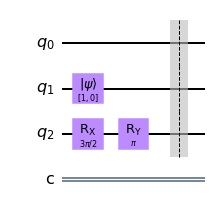

In [897]:
init_circ(zero, np.pi, 3/2*np.pi)

#### d. Full SWAP Circuit + Probability Output

This method combines all the previous method to create a full SWAP test circuit from start to finish

In [898]:
def SWAP_test(constant_vector, phi_test, theta_test, visual = True):
    
    """
    Full SWAP test circuit
    
    Parameter:
    ----------
    constant_vector: ndarray
        Initial statevector for the constant qubit
        
    phi_test: float 
        Angle of rotation for R_y gate [0, 2*np.pi)
        
    theta_test: float
        Angle of rotation for R_x gate [0, 2*np.pi)
    
    visual: bool (True)
        Draw circuit option
        
    Returns:
    --------
    P_0: float
        Probability of getting |0>
    
    """

    # Build Full Circuit
    circ = init_circ(constant_vector, phi_test, theta_test, False) + SWAP_circ(False)

    # Calculate probability
    P_0 = prob_0(circ, False)
    
    # Draw Circuit
    if visual:
        circ.draw('mpl')

    return P_0

#### e. Random Search Method

We are going to find the best values for $\phi, \theta$ using a random search.

The random search method will randomly generate a $\phi$ and $\theta$ values from a uniform distribution. This is better than a normal grid search, because we get to interact with a bigger number of different values.

The random generator method generates a list of $\phi, \theta$ as a 2-d vectors

In [842]:
random_generator = lambda n: np.random.uniform(low = 0, high = 2*np.pi, size = (n, 2))
random_generator.__doc__ = "n: the number of phi, theta pairs"

Finally, to random search for the optimal parameters, loop over each pair fo $\phi, \theta$  in the list

Recall that for a constant state $\delta$ and a test state $\psi$, the SWAP test tells us

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \delta \ \rangle|^2)$$

When $\psi$ is identical to $\delta$, 

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \psi \ \rangle|^2) = \frac{1}{2} \ (1 + 1) = 1$$

We will get $|0\rangle$ with 100% probability

On the other hand, when $\psi$ is orthogonal to $\delta$,

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \psi \ \rangle|^2) = \frac{1}{2} \ (1 + 0) = \frac{1}{2}$$

We will get $0\rangle$ with 50% probability

All other states will return probability of gettin $|0\rangle$ between 50% and 100%

For our random search, we want to find values of $\phi, \theta$ that return $\psi$ that most closely ressembles $\delta$, so we want to maximize the probability of getting $|0\rangle$.

In [905]:
# Constant Vector
constant_vector = one

n = 5

def random_search(constant_vector, no_pairs):
    
    """
    Find the optimal values of phi, and theta using random search
    
    Parameters:
    -----------
    constant_vector: ndarray
        Initial statevector for the constant qubit
    no_pairs: int
        number of phi, theta pairs"
        
    Returns:
    --------
    phi_max: float [0, 2pi)
        Value of Ry rotation that produces the most similar qubit to the constant state
    theta_max: float [0, 2pi)
        Value of Rx rotation that produces the most similar qubit to the constant state
    
    """
    
    # Create empty probability list
    prob_list = np.array([])

    # Create table of values
    table = random_generator(n)

    # Iterate over each phi, theta pair
    for pair in table:

        phi_test, theta_test = pair
        prob_ex = SWAP_test(constant_vector, phi_test, theta_test, visual = False)

        prob_list = np.append(prob_list, prob_ex)

    # Get the index of the the max probability, and locate phi, theta
    phi_max, theta_max = np.squeeze(table[np.where(prob_list == max(prob_list))])

    print(f'Optimal phi: {phi_max}')
    print(f'Optimal theta: {theta_max}')
    
    return phi_max, theta_max

In [906]:
# Test with constant vector as |1>
constant_vector = one

phi, theta = random_search(constant_vector, 1000)

Optimal phi: 0.16289931889153858
Optimal theta: 3.4536312049154296


In [907]:
# Run it back through the SWAP test circuit
SWAP_test(constant_vector, phi, theta, visual = False)

0.98828125

### Part 3:

#### a. Method to product hidden product state

Here, an 'n' qubits product state is generated. In this case, the process looks very similar to generating a random binary string.

In [908]:
hidden_CBS = lambda no_qubits: np.array([zero if np.random.randint(0, 2) == 0 else one for _ in range(no_qubits)])

In [914]:
view(np.squeeze(hidden_CBS(3)))

Matrix([
[0, 1],
[0, 1],
[1, 0]])

#### b. SWAP test on product state method

We can use the random search SWAP test method from part '2e' above to find the correct product state

In [919]:
def SWAP_product(hidden_box):
    
    """
    Find the hidden product state using SWAP test on individual qubits
    
    Parameters:
    -----------
    product_state: list
        List of |0> or |1> qubits
    
    Returns:
    --------
    guess_list: list
        List of guesses
        
    """
    
    # Initialize the list of guesses
    guess_list = []

    # Iterate over qubits in the product state
    for constant_vector in hidden_box:

        # Test for |0>
        test_zero = SWAP_test(constant_vector, 0, 0, visual = False)

        # Set a threshold to distinguish between the two output states
        if test_zero > 0.75:
            guess_list.append(0)
        else:
            guess_list.append(1)

    # Represent the hidden box as binary for verification
    hidden_box_bin = [0 if np.all(elem == zero) else 1 for elem in hidden_box]

    # Assert that our guesses are correct
    assert guess_list == hidden_box_bin
    
    return guess_list

In [920]:
product_state = hidden_CBS(3)

In [921]:
# Discover the product state using the 'SWAP_product' method
SWAP_product(product_state)

[1, 0, 0]

In [924]:
a = np.random.rand(10)

In [926]:
b = [1, 3, 5]

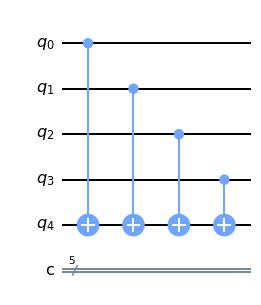

In [19]:
circ = QuantumCircuit(5, 5)
for i in range(4):
    circ.cx(i, 4)
    
circ.draw('mpl')

In [15]:
sim(circ)

{'00000': 64,
 '10001': 67,
 '10010': 56,
 '10100': 67,
 '10111': 71,
 '11000': 58,
 '11011': 65,
 '11101': 67,
 '11110': 65,
 '00011': 50,
 '00101': 59,
 '00110': 67,
 '01001': 76,
 '01010': 66,
 '01100': 60,
 '01111': 66}